# Predicting Retweets of @realDonaldTrump Twitter account. 

## Abstract
Twitter is one of the most popular platforms for expressing opinions, thoughts and updates, but it is also used to influence people and is a "tactic" widely used in election campaigns. President Donald Trump's Twitter account is very popular, his tweet frequency is relatively high, and his tweets are liked and retweeted hundreds of thousands of times.

This notebook implements a regression model to predict the number of retweets of a particular tweet from @realdonaldtrump. Additionally the meaning of features is evaluated and compared.

The result of this notebook is, besides the prediction model, a set of important characteristics for a high number of retweets. These can be used to increase the retweet rate of candidates for future election campaigns. Our model can be used to decide on which parts to focus on when tweeting (length, specific hashtags, time of day, etc.) in order to maximize the number of retweets and gain popularity or even become viral.

## Data Selection

For the task of this notebook the Tweets and the Retweet counts of the @realdonaldtrump Twitter account are needed. This notebooks uses the data from http://trumptwitterarchive.com/archive. The data spans from Donald J. Trumps inauguration on January 20, 2017 until April 30, 2020. 

In [86]:
#import data from http://trumptwitterarchive.com/archive
import pandas as pd

twitterdata = pd.read_json("data.json")

## Data Exploration

Initial exploration of the dataset.  

In [87]:
#dimension of dataset
dimension_twitterdata = twitterdata.shape
print("The dataset has " + str(dimension_twitterdata[0]) + " records and " +
      str(dimension_twitterdata[1]) + " variables." )

The dataset has 13427 records and 5 variables.


In [88]:
#show the first 10 records of the dataset
print(twitterdata.head(10))

               source                                               text  \
0  Twitter for iPhone  White House news conference at 5:00 P.M. Easte...   
1  Twitter for iPhone                            https://t.co/2hKJkP5Z6N   
2  Twitter for iPhone  On #NationalDoctorsDay, we recognize the remar...   
3  Twitter for iPhone                            https://t.co/nzWJ8ViwbZ   
4  Twitter for iPhone  Nancy Pelosi and the Democrats delayed the Wor...   
5  Twitter for iPhone  Thank you Dr. Hahn &amp; the FDA for your fast...   
6  Twitter for iPhone  Will be interviewed on @foxandfriends at 7:55 ...   
7  Twitter for iPhone                            https://t.co/YzhyVR1N6d   
8  Twitter for iPhone                            https://t.co/MtEehGY9cp   
9  Twitter for iPhone  Will be starting The White House news conferen...   

                 created_at  retweet_count               id_str  
0 2020-03-30 20:50:35+00:00          14441  1244728753617620992  
1 2020-03-30 17:46:15+00:00    

In [89]:
#show variables and variables type
print(twitterdata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13427 entries, 0 to 13426
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   source         13427 non-null  object             
 1   text           13427 non-null  object             
 2   created_at     13427 non-null  datetime64[ns, UTC]
 3   retweet_count  13427 non-null  int64              
 4   id_str         13427 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(2)
memory usage: 524.6+ KB
None


The variables in the dataset are source, text, created_at, retweet_count, id_str.

Explanation of the variables. 
* **source** is the kind of device used for the tweet.
* **text** is content of the tweet.
* **created_at** is the timestamp of the tweet in UTC.
* **retweet_count** is number of retweets of the tweet.
* **id_str** is an unique identifier of the tweet.

### Missing data
It can already be seen, that there is no missing data.

### Duplicates

In [90]:
#check for duplicates
dublicated_entries = twitterdata.duplicated(keep = False)
print("There are " + str(dublicated_entries.sum()) + " duplicated entries.")

There are 0 duplicated entries.


In [91]:
#check for duplicate texts
dublicated_text = twitterdata.loc[:, ["text"]].duplicated(keep = False)
print("There are " + str(dublicated_text.sum()) + " duplicated text of tweets.")

There are 243 duplicated text of tweets.


In [92]:
#show tweets with duplicated text.
print(twitterdata[dublicated_text].sort_values(by='created_at').tail(10))

                 source                                               text  \
604  Twitter for iPhone        ....THE UNITED STATES IS OPEN FOR BUSINESS!   
603  Twitter for iPhone  ....I have seen some of the regulations being ...   
602  Twitter for iPhone  ....product and goods to China and other count...   
601  Twitter for iPhone  “Judge Jackson now has a request for a new tri...   
600  Twitter for iPhone  .....would order a new trial, I’m not so sure ...   
599  Twitter for iPhone  .....existence of these tweets in which you we...   
391  Twitter for iPhone  Australia’s Central Bank cut interest rates an...   
389  Twitter for iPhone  Australia’s Central Bank cut interest rates an...   
137  Twitter for iPhone                            https://t.co/ytgBP3hJv1   
81   Twitter for iPhone                            https://t.co/ytgBP3hJv1   

                   created_at  retweet_count               id_str  
604 2020-02-18 15:29:43+00:00           9968  1229790102949449728  
603 2

There are a few dupplicated text, which will be analyzed further. It can be seen that there are text that are repeated, like "MAKE AMERICA GREAT AGAIN" which are not a problem. But on the other site there are text, which seem like they were deleted and reposted later. It is difficult to check which one them is a real retweet and which of them was deleted. Therefore it is out of scope in this project to delete the tweets.

### Check the target class retweet_count
The target class is the number of retweets of a tweet. This is represented in the data as integer (int64).

In [93]:
#maximum of the retweet value
print("The maximal retweet value is " + str(twitterdata.loc[:,'retweet_count'].max()) + "." )

The maximal retweet value is 369530.


Seems legitimate so far.

In [94]:
#minimum of the retweet value
print("The minimal retweet value is " + str(twitterdata.loc[:,'retweet_count'].min()) + "." )

The minimal retweet value is 0.


Seems like there is an outlier here. One hypothesis is that these are the tweets which are deleted and appear two times in the dataset. It cannot be finally confirmed, since we do not have a label for deleted tweets and not every tweet, which was deleted is tweeted again later. If you go back to the site http://www.trumptwitterarchive.com/archive you can see that every tweet here is not availabe anymore. It was probably posted and shortly after deleted. For example one tweet has 0 retweets, which is deleted. But Trump posted the exact same tweet one minute after this tweet and it got 8000 retweets: https://twitter.com/realdonaldtrump/status/1235034836705959936.

In [95]:
#other summary statistics
twitterdata.loc[:,'retweet_count'].describe()

count     13427.000000
mean      19149.517986
std       12661.057625
min           0.000000
25%       11898.000000
50%       17132.000000
75%       23767.500000
max      369530.000000
Name: retweet_count, dtype: float64

So far so good it looks like there is an skewed distribution of the values.

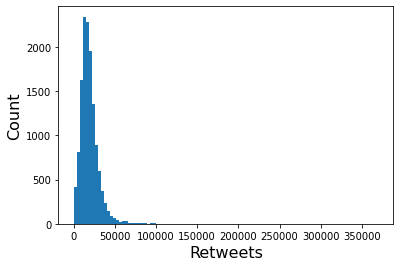

In [97]:
#visualize the retweet frequenzy as histogramm
import matplotlib.pyplot as plt
plt.hist(twitterdata["retweet_count"], bins = 100)
plt.xlabel('Retweets', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

It can be seen that there is an highly skewed distribution with an long tail. First visual impression shows an one sided truncated normal distribution.

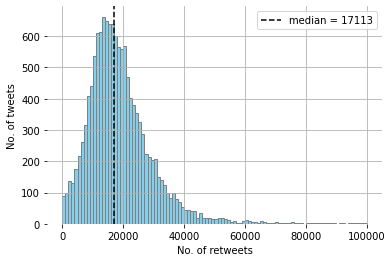

Median for retweets: 17113.0


In [98]:
#visualize the retweet frequenzy as histogramm for retweet_count < 100.000
twitterdata_truncated = twitterdata[twitterdata["retweet_count"] < 100000].loc[:, "retweet_count"]
plt.hist(twitterdata_truncated, bins = 100, color="skyblue", edgecolor='grey')
plt.axvline(twitterdata_truncated.median(), color='black', linestyle='dashed', linewidth=1.5, label='median = ' + 
            str(round(twitterdata_truncated.median())))
plt.xlabel('No. of retweets', fontsize=10)
plt.ylabel('No. of tweets', fontsize=10)
plt.box(False)
plt.grid()
plt.legend()
plt.savefig("retweets.png")
plt.show()

print("Median for retweets: " + str(twitterdata_truncated.median()) )

Seems like the inital hypothesis is confirmed.

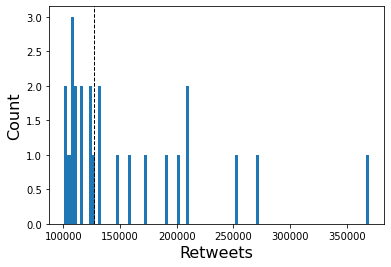

In [99]:
#visualize the retweet frequenzy as histogramm for retweet_count > 100.000
twitterdata_truncated = twitterdata[twitterdata["retweet_count"] > 100000].loc[:, "retweet_count"]
plt.hist(twitterdata_truncated, bins = 100)
plt.axvline(twitterdata_truncated.median(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Retweets', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

There seems nothing wrong here.

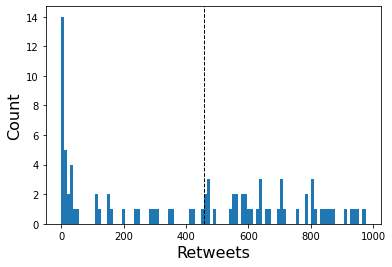

In [100]:
#visualize the retweet frequenzy as histogramm for retweet_count < 1.000
twitterdata_truncated = twitterdata[twitterdata["retweet_count"] < 1000].loc[:, "retweet_count"]
plt.hist(twitterdata_truncated, bins = 100)
plt.axvline(twitterdata_truncated.median(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Retweets', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

Seems like there especially many tweets that have retweet count 0. These will most likely be deleted tweets. The rest could also be deleted tweets.

The first analysis of the retweet count shows that the data is so far so good. The only problem are the potentially deleted tweet, which cannot be analyzed in this first project.

### Check the attribute source
This is represented in the data as strings (object).

In [101]:
#check how many distinct values there are. 
twitterdata_source_unique = twitterdata.loc[:,'source'].unique()
print("There are " + str(twitterdata_source_unique .size) + " distinct values.")

There are 8 distinct values.


In [102]:
#show the different values
print("The different values are:")
print(twitterdata_source_unique)

The different values are:
['Twitter for iPhone' 'Twitter Media Studio' 'Twitter Web App'
 'Twitter Web Client' 'Twitter for iPad' 'Media Studio' 'Twitter Ads'
 'Twitter for Android']


In [103]:
#show the frequency of the different values
twitterdata_source_frequency = twitterdata.groupby(by = "source").count().loc[:,"retweet_count"]
print(twitterdata_source_frequency)

source
Media Studio              155
Twitter Ads                33
Twitter Media Studio      159
Twitter Web App             4
Twitter Web Client         48
Twitter for Android       173
Twitter for iPad           35
Twitter for iPhone      12820
Name: retweet_count, dtype: int64


It can be seen that there are very infrequent classes. It has to be seen, if these should be binned into on class or if they have prediction power. Therefore the next step is to analyze the retweet count based on the source.

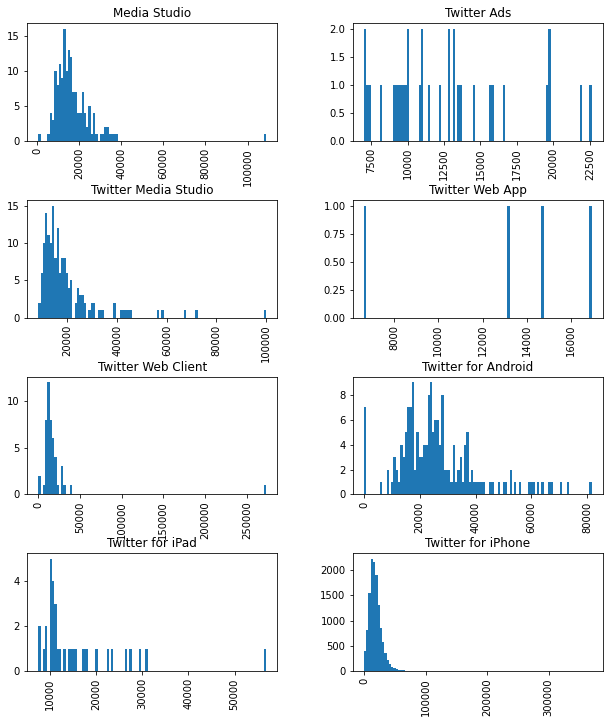

In [104]:
#visualize retweet count based on source
twitterdata_source_hist = twitterdata.hist(column='retweet_count', by='source', bins=100, grid=False, figsize=(10,12), layout=(4,2))

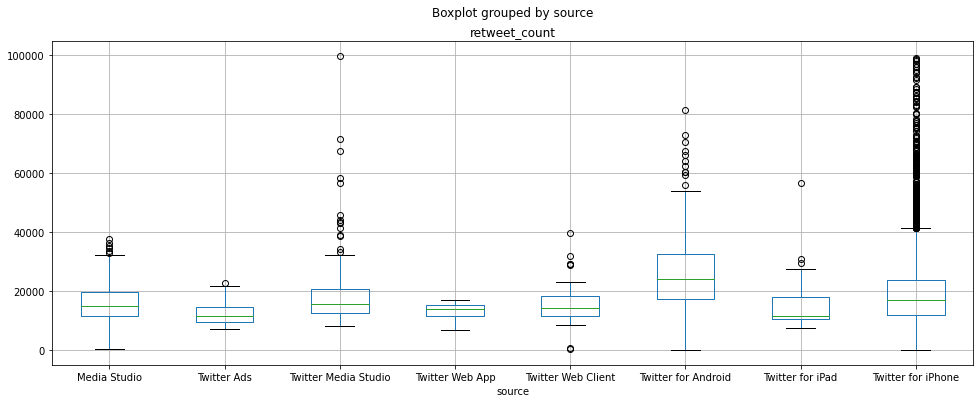

In [105]:
#use boxplots for more clear results
twitterdata_source_boxplot = twitterdata[twitterdata["retweet_count"] < 100000].boxplot(column='retweet_count', by='source', figsize = (16,6))

Seems like there are differences. Binn the most infrequent values to show more significant results. 

In [106]:
#bin values
twitterdata['source_binned'] = twitterdata["source"].replace({'Media Studio': 'Video', 'Twitter Media Studio': 'Video',
                                                              'Twitter Ads' : "others", 'Twitter Web App' : 'others',
                                                              'Twitter Web Client' : 'others', 'Twitter for iPad' : 'others'
                                                             }).astype('category').cat.codes

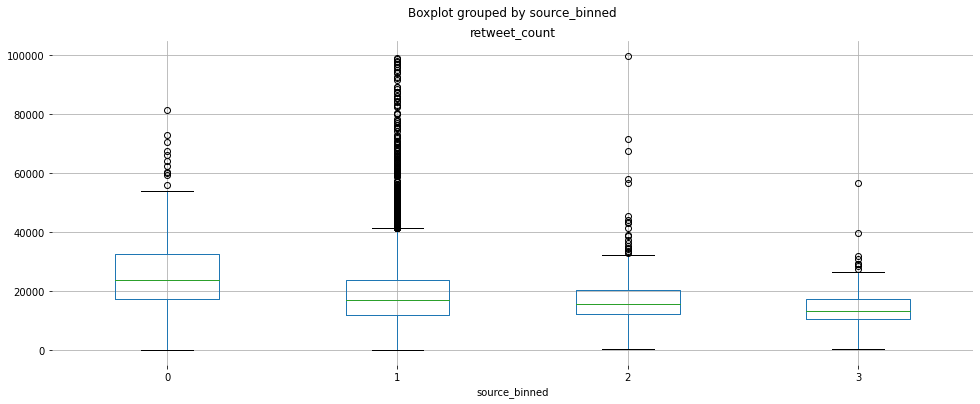

In [107]:
#visualy compare the two categories
twitterdata_source_boxplot = twitterdata[twitterdata["retweet_count"] < 100000].boxplot(column='retweet_count', by='source_binned', figsize = (16,6))
plt.box(False)

That looks more promising.

In [108]:
twitterdata = twitterdata.drop("source", axis=1)

### Check the attribute created_at
This is represented in the data as time (datetime64[ns, UTC]).

In [109]:
#check the basis statistics
twitterdata.loc[:,'created_at'].describe()

count                         13427
unique                        13054
top       2019-05-10 11:22:22+00:00
freq                              4
first     2017-01-20 00:40:51+00:00
last      2020-03-30 20:50:35+00:00
Name: created_at, dtype: object

The data range is the targeted. What is noticable that there non unique values. These are further investigated. 

In [110]:
#show tweets with duplicated dates.
dublicated_text = twitterdata.loc[:, ["created_at"]].duplicated(keep = False)
print("There are " + str(dublicated_text.sum()) + " duplicated dates of tweets.")

There are 710 duplicated dates of tweets.


In [111]:
#check for duplicate texts
print(twitterdata[dublicated_text].sort_values(by='created_at').head(6))

                                                    text  \
12815             Big win in Montana for Republicans! We   
12814  Just arrived in Italy after having a very succ...   
10645  Looks like Jerry Brown and California are not ...   
10646  So many people are seeing the benefits of the ...   
10640  Today’s Court decision means that Congress mus...   
10641  ....Congress – House and Senate must quickly p...   

                     created_at  retweet_count              id_str  \
12815 2017-05-28 11:57:20+00:00            428  868798339676086272   
12814 2017-05-28 11:57:20+00:00            416  868798339671830528   
10645 2018-04-17 12:24:36+00:00          15332  986218870506754048   
10646 2018-04-17 12:24:36+00:00          15379  986218871991492608   
10640 2018-04-17 21:34:23+00:00          15804  986357228306354176   
10641 2018-04-17 21:34:23+00:00          13120  986357230219022336   

       source_binned  
12815              1  
12814              1  
10645              

Seems like there is no fixable mistake with the duplicated dates.

Since the data is in UTC +00, it needs to be changed eastern time zone, washington -5.

In [112]:
#change timezone 
twitterdata['created_at_utc'] = twitterdata['created_at']
twitterdata['created_at'] = pd.DatetimeIndex(twitterdata['created_at']).tz_convert('America/New_York')

It is the best guess to change the time to Washington time zone. If he is in other time zones it can not be seen. It also does not necessary have an real impact, since the time difference remains the same. 

In [113]:
#create hour of the day and date as attributes
twitterdata['created_at_hour'] = twitterdata["created_at"].dt.hour.astype('category').cat.codes
twitterdata['created_at_date'] = twitterdata["created_at"].dt.date

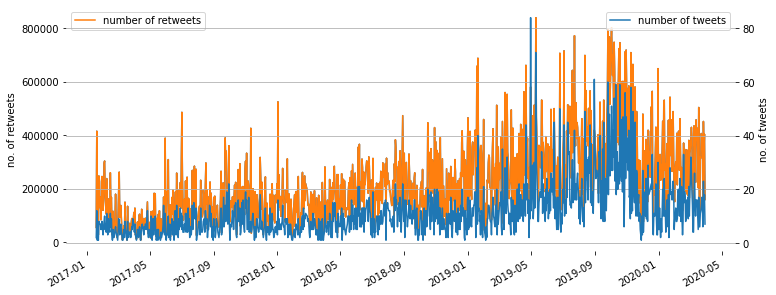

In [114]:
#check if there a times where no data is available 
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from matplotlib.legend_handler import HandlerLine2D
#check if there a times where no data is available 
retweets = twitterdata.groupby("created_at_date").sum().loc[:,"retweet_count"]
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(retweets)
ax1.plot(retweets, label = 'number of retweets')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.legend(loc=0)
ax1.set_ylabel("no. of retweets")
plt.box(False)
ax1.xaxis.set_major_locator(MaxNLocator(20))
ax2 = ax1.twinx() 
tweets = twitterdata.groupby("created_at_date").count().loc[:,"retweet_count"]
ax2.plot(tweets, label = 'number of tweets')
ax2.legend(loc=0)
fig.autofmt_xdate()
plt.xlabel('date', fontsize=10)
plt.ylabel('no. of tweets', fontsize=10)
plt.box(False)
plt.grid()
plt.savefig("created_at.png")

Seems like there are no relevant timeperiods without tweets. 

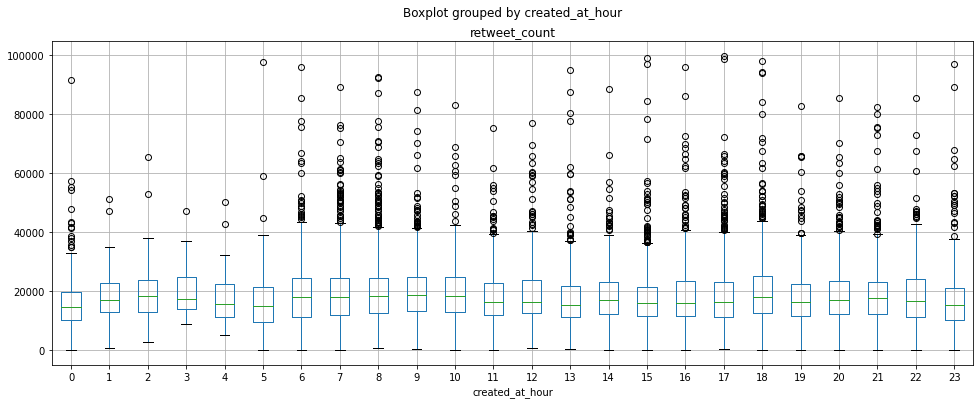

In [115]:
#check if time of the day is relevant feature
twitterdata_source_boxplot = twitterdata[twitterdata["retweet_count"] < 100000].boxplot(column='retweet_count', by='created_at_hour', figsize = (16,6))

There a no immense differences but small changes. Therefore the values are binned into times of day.

In [116]:
#create feature times of day
twitterdata["created_at_daytime"] = pd.cut(twitterdata['created_at_hour'],[0,6,12,18,24], labels = ['Night', 'Morning', 'Afternoon', 'Evening'],include_lowest=True).cat.codes

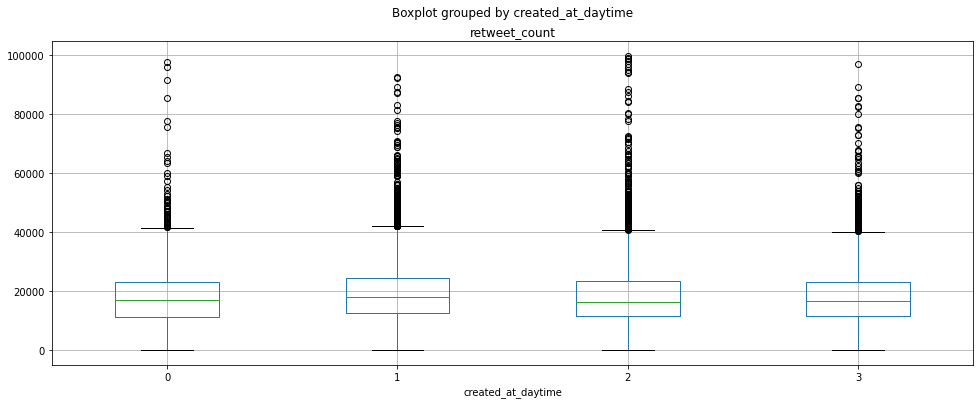

In [117]:
#show impact of feature times of day
twitterdata_source_daytime_boxplot = twitterdata[twitterdata["retweet_count"] < 100000].boxplot(column='retweet_count', by='created_at_daytime', figsize = (16,6))

In [118]:
#create feature day of the week
twitterdata["created_at_weekday"] = twitterdata["created_at"].dt.day_name().astype('category').cat.codes

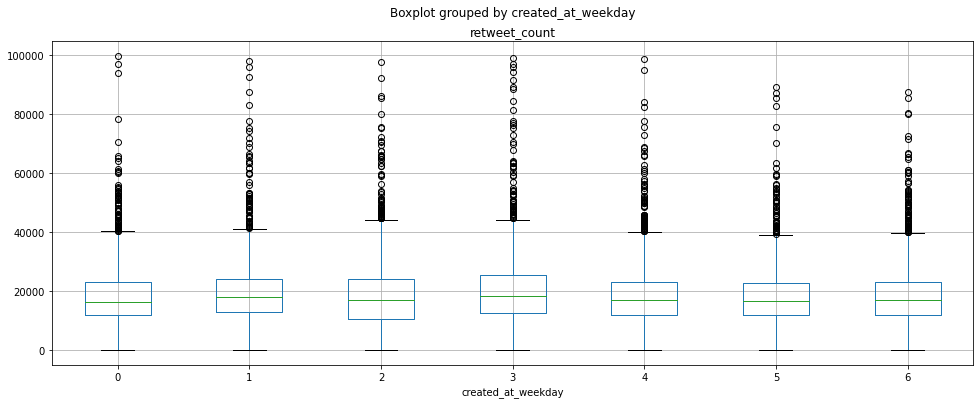

In [119]:
#show impact of feature day of the week
twitterdata_source_weekday_boxplot = twitterdata[twitterdata["retweet_count"] < 100000].boxplot(column='retweet_count', by='created_at_weekday', figsize = (16,6))

In [121]:
#create feature month
twitterdata["created_at_month"] = twitterdata["created_at"].dt.month.astype('category').cat.codes

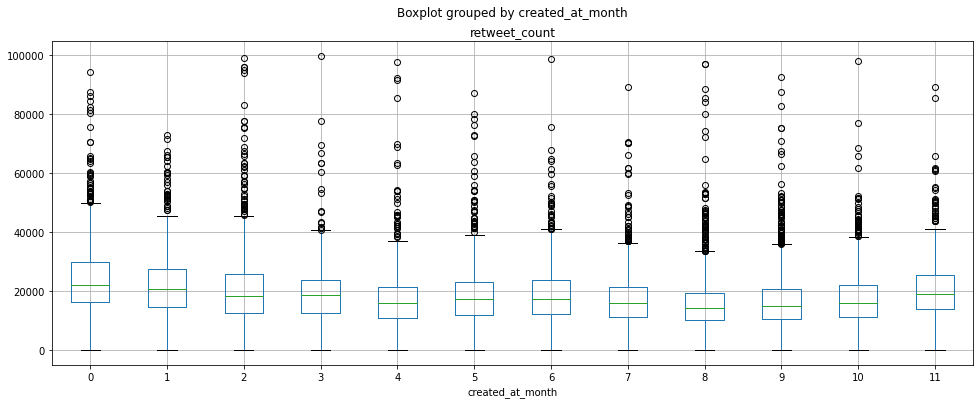

In [122]:
#show impact of feature month
twitterdata_source_month_boxplot = twitterdata[twitterdata["retweet_count"] < 100000].boxplot(column='retweet_count', by= 'created_at_month', figsize = (16,6))

In [123]:
#create feature age of the tweet in days
from pytz import timezone
from datetime import datetime
date_inaguration = datetime(2017, 1, 20, 0, 0, 1).astimezone(timezone("America/New_York")) #the date Trump was inaugurated
twitterdata['created_at_age_days'] = (twitterdata['created_at'] - date_inaguration).dt.days
twitterdata['created_at_age_months'] = round((twitterdata['created_at'] - date_inaguration).dt.days/30,0)

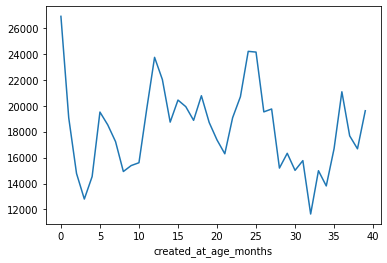

In [124]:
#plot the development of retweets median per month
twitterdata.groupby("created_at_age_months").median()["retweet_count"].plot.line()

Seems like this will be a good feature later.

In [125]:
twitterdata = twitterdata.drop(["created_at","created_at_utc","created_at_date","created_at_age_months"], axis=1)

### Check the attribute  id_str  
This is represented in the data as integer (integer64).

In [126]:
#check if this is a unique identifier
if twitterdata["id_str"].nunique() == twitterdata.shape[0]:
    print("This is a unique identifier.")

This is a unique identifier.


In [127]:
#drop id_str
twitterdata = twitterdata.drop("id_str", axis = 1)

It is not needed anymore.

### Check the attribute text 
This is represented in the data as strings (object).

In [128]:
#short summary of the attribute
twitterdata['text'].describe()

count                         13427
unique                        13278
top       MAKE AMERICA GREAT AGAIN!
freq                             22
Name: text, dtype: object

The topic of duplicated entries was already discussed before. 

Now it needs to be understood how the strings are decoded and and how
* videos
* smiley
* hashtags
* mentions
* urls
* images

are stored

#### Video 
All tweets by Twitter Media Studio or Media Studio contain self hosted videos.These are already included as feature in source_binned.

#### Smileys
Smiley will be taken as feature trough the tokenization. A next step would be to check the meaning of the smileys and order them into a new category.

####  Hashtags
Extract hastages with regex. Will be implemented in a function to make it possible to include it in cross-validation.

In [129]:
#extract hashtags
import re
#define function to get hashtags
def hashtags(text):
    pattern = re.compile(r"#(\w+)")
    hashtags = pattern.findall(text)
    return hashtags

#apply to dataset
twitterdata['hashtag_content'] =  twitterdata.apply(lambda x: hashtags(x['text']), axis=1)

#if tweet contains hashtag (boolean)
twitterdata['hashtag_included'] =  twitterdata.apply(lambda x: int(len(x['hashtag_content']) > 0) , axis=1)

# number of hashtags
twitterdata['hashtag_number'] =  twitterdata.apply(lambda x: len(x['hashtag_content']), axis=1)

In [130]:
#define function build dictionary to search for most used hashtags 
def create_dictionary_hashtags(data):
    dictionary_hashtags = {} #initialize empy dictionary
    
    def remove_punctuation_hsht(text):
        for punctuation in string.punctuation:
            if punctuation != '#': # leave exclamation mark
                text = text.replace(punctuation, '')
        return text
    
    twitterdata['hashtag_content'] =  twitterdata.apply(lambda x: remove_punctuation_hsht(x['text']), axis=1)
   
    #build dictionary
    for i in data.index:
        tweet_text = data['text'][i]
        tweet_text_tokenized = tweet_text.split()
    
        #check for hashtags
        for word in tweet_text_tokenized:
            if (word[0:1] == '#' and len(word) > 1):
                if word in dictionary_hashtags:
                    dictionary_hashtags[word] += 1
                else:
                    dictionary_hashtags[word] = 1
                    

    #transform to dataframe
    dataframe_hashtags = pd.DataFrame(dictionary_hashtags.items(), columns=['Hashtag', 'occurences'])
    
    #return dataframe
    return dataframe_hashtags

In [131]:
#build dictionary to search for most used hastags 
dataframe_hashtags = create_dictionary_hashtags(twitterdata)

In [132]:
#analyze dataframe
print("There are " + str(dataframe_hashtags.shape[0]) + " different hashtags.")
dataframe_hashtags.sort_values("occurences", ascending = False).head(n = 10)

There are 712 different hashtags.


,Hashtag,occurences
2,#MAGA,161
12,#KAG2020,58
51,#MAGA🇺🇸,31
520,#USA🇺🇸,23
178,#Dorian,17
21,#KAG,15
111,#1,15
142,#FakeNews,14
162,#UNGA,13
50,#USMCA,12


In [133]:
twitterdata = twitterdata.drop("hashtag_content", 1)

Since the goal is to have a generalizable model, which extract actionable knowledge Hashtags with occurences smaller than a threshold will be ignored. The rest will be extracted and added as a feature.

A next possible step is to bin the hashtags in different categories. This is out of scope of this project.

#### Mentions
Extract mentions with regex.

In [134]:
#extract mentions
#define function to get mentions
def mentions(text):
    pattern = re.compile(r"@(\w+)")
    mentions = pattern.findall(text)
    return mentions

#apply to dataset
twitterdata['mentions_content'] =  twitterdata.apply(lambda x: mentions(x['text']), axis=1)

#if tweet contains hashtag (boolean)
twitterdata['mentions_included'] =  twitterdata.apply(lambda x: int(len(x['mentions_content']) > 0) , axis=1)

# number of hashtags
twitterdata['mentions_number'] =  twitterdata.apply(lambda x: len(x['mentions_content']), axis=1)

In [135]:
#define function build dictionary to search for most used mentions
def create_dictionary_mentions(data):
    dictionary_mentions = {} #initialize empy dictionary
    
    def remove_punctuation_mn(text):
        for punctuation in string.punctuation:
            if punctuation != '@': # leave exclamation mark
                text = text.replace(punctuation, '')
        return text
    
    twitterdata['text'] =  twitterdata.apply(lambda x: remove_punctuation_mn(x['text']), axis=1)
    
    #build dictionary
    for i in data.index:
        tweet_text = data['text'][i]
        tweet_text_tokenized = tweet_text.split()
    
        #check for hashtags
        for word in tweet_text_tokenized:
            if (word[0:1] == '@' and len(word) > 1):
                if word in dictionary_mentions:
                    dictionary_mentions[word] += 1
                else:
                    dictionary_mentions[word] = 1

    #transform to dataframe
    dataframe_mentions = pd.DataFrame(dictionary_mentions.items(), columns=['Mentions', 'occurences'])
    
    #return dataframe
    return dataframe_mentions

In [136]:
#build dictionary to search for most used mentions
dataframe_mentions = create_dictionary_mentions(twitterdata)

In [137]:
#analyze dataframe
print("There are " + str(dataframe_mentions.shape[0]) + " different mentions.")
dataframe_mentions.sort_values("occurences", ascending = False).head(n = 10)

There are 1470 different mentions.


,Mentions,occurences
246,@realDonaldTrump,510
20,@FoxNews,308
14,@WhiteHouse,293
1,@foxandfriends,235
115,@FLOTUS,82
308,@GOPChairwoman,79
19,@seanhannity,79
282,@TomFitton,77
6,@nytimes,74
21,@LouDobbs,74


Since the goal is to have a generalizable model, which extract actionable knowledge menntions with occurences of less than a treshold. will be ignored.

In [138]:
twitterdata = twitterdata.drop("mentions_content", 1)

A possible next step is to cluster the different mentioned users into groups like Republicans and Democrat. This is out of scope of this project.

#### Urls
Extract urls.

In [139]:
#extract urls
#define function to get urls
def urls(text):
    pattern = re.compile(r"http\S+")
    urls_content = pattern.findall(text)
    return urls_content

#apply to dataset
twitterdata['urls_content'] =  twitterdata.apply(lambda x: urls(x['text']), axis=1)

#if tweet contains url (boolean)
twitterdata['urls_included'] =  twitterdata.apply(lambda x:  int(len(x['urls_content']) > 0) , axis=1)

In [140]:
#build dictionary to search for most used urls
dictionary_urls = {} #initialize empy dictionary

#build dictionary
for i in twitterdata.index:
    tweet_text = twitterdata['text'][i]
    tweet_text_tokenized = tweet_text.split()
    
    #check for hashtags
    for word in tweet_text_tokenized:
        if (word[0:4] == 'http'):
            if word in dictionary_urls:
                dictionary_urls[word] += 1
            else:
                dictionary_urls[word] = 1

#transform to dataframe
dataframe_urls = pd.DataFrame(dictionary_urls.items(), columns=['Url', 'occurences'])

In [141]:
#analyze dataframe
print("There are " + str(dataframe_urls.shape[0]) + " different urls.")
dataframe_urls.sort_values("occurences", ascending = False).head(n = 5)

There are 4016 different urls.


,Url,occurences
795,https…,25
2481,httpstco0pWiwCHGbh,21
1004,httpst…,16
1147,httpstco…,11
977,httpstc…,8


Seems like there is no real frequent urls. Therefore they will not be used further. A next possible step would be to check if the content of the urls contains valuable information. This is out of scope of this project.

In [142]:
twitterdata = twitterdata.drop("urls_content", 1)

#### Images
Images could be possible detected by analysis of the url. This is out of scope for this project.

#### Text feature creation
From the text there are many possibilities to create features.

In [143]:
#create feature length of tweets
twitterdata["text_lenght"] = twitterdata["text"].apply(len)

In [144]:
#create function find capslocked words
def is_uppercase(text):
    result = 0
    for word in text.split():
        if word.isupper() == True and len(word) > 1:
            result = 1
            break
    return result
    
#create feature includes word in capslock
twitterdata["capslock_contained"] = twitterdata.apply(lambda x: is_uppercase(x['text']), axis=1)

#### Preprocess text

Define function which preprocess the text

In [145]:
#remove urls 
def remove_urls(text):
    return re.sub(r"http\S+", '', text)

In [146]:
#remove hashtags with words
def remove_hashtags(text):
    return re.sub(r"#+", '', text)

In [147]:
#remove mentions with words
def remove_mentions(text):
        return re.sub(r"@+", '', text)

In [148]:
# remove punctuation
import string
def remove_punctuations(text):
    for punctuation in string.punctuation:
        if punctuation != '!': # leave exclamation mark
            text = text.replace(punctuation, '')
    return text

In [149]:
#remove numbers 
def remove_numbers(text):
    return re.sub('[0-9]+', '', text)

In [150]:
#remove special characters
def remove_special(text):
    for char in ['€','�','‡','†','‰','™','•','–', '—',]:
        text = text.replace(char, '')
    return text

In [151]:
#make word lowercase
def lower_case(text):
    to_lowercase = lambda text: " ".join(word if (word.isupper() == True & len(word) > 1) else word.lower()
            for word in text.split())
    lowercase = to_lowercase(text)   
    return lowercase

In [152]:
def stop_words(text, stop):
    remove_stop = lambda text: " ".join(word for word in text.split() if word not in stop)
    filtered = remove_stop(text)
    return filtered

#### Lemmatization text

In [153]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

#define function for lemmatization
def lemmatize_text(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_text = []
    for word in text.split():
        lemmatized_text.append(wordnet_lemmatizer.lemmatize(word,pos="v"))
    return " ".join(lemmatized_text)

### Most frequent words

In [154]:
from collections import Counter
preprocessed_text = preprocess_text(twitterdata)
pd.Series(' '.join(preprocessed_text['text']).split()).value_counts()[:20]

great        2709
rt           2138
amp          2133
get          1337
president    1336
people       1317
thank        1124
make         1111
democrats    1098
go           1045
state        1042
us           1022
news          972
country       928
border        888
trump         887
job           869
fake          859
big           843
want          833
dtype: int64

It would be possible to work even more with the text and use thing like uppercase as a feature. Further methods like embeddings and further preprocessing could be applied to improve results. This is out of scope of this project.

## Feature selection

Steps taken are:
* took hashtags only with treshold amount of appearances
* took mentions only with treshold amount of appearances
* preprocess the text
* took words only with treshold amount of appearances
* select features based on kendall correlation measure

To build a pipeline for cross-validation it is needed to change the preprocessing steps and the feature generation and selection process into classes. 

### Build classes

In [129]:
from sklearn.base import BaseEstimator, TransformerMixin

#define classes for the hashtag feature generation for the pipeline
class generate_feature_hashtag_transformer(BaseEstimator, TransformerMixin):

    #define init method
    def __init__(self, treshold = 50):
        self.treshold = treshold

    #define fit method
    def fit(self, data, y=None):
        
        #generate hashtag dictionary
        data['hashtag_content'] = data.apply(lambda x: hashtags(x['text']), axis=1)
        dataframe_hashtags = create_dictionary_hashtags(data)
        self.index_threshold = dataframe_hashtags[dataframe_hashtags["occurences"] > self.treshold]["Hashtag"]
        
        return self

    #define transform method
    def transform(self, data):
        
        if "hashtag_content" not in data.keys():
            data['hashtag_content'] = data.apply(lambda x: hashtags(x['text']), axis=1)
        
        for index, value in self.index_threshold.items():
            data[str(value)] = data['text'].str.contains(re.compile(value))

        
        data_feature_added = data.drop("hashtag_content", 1)
        
        #return dataset with added feature
        return data_feature_added

In [67]:
#define classes for the mentions feature generation for the pipeline
class generate_feature_mentions_transformer(BaseEstimator, TransformerMixin):

    #define init method
    def __init__(self, treshold = 2):
        self.treshold = treshold

    #define fit method
    def fit(self, data, y=None):
        
        #generate mentions dictionary
        data['mention_content'] = data.apply(lambda x: mentions(x['text']), axis=1)
        dataframe_mentions = create_dictionary_mentions(data)
        self.index_threshold = dataframe_mentions[dataframe_mentions["occurences"] > self.treshold]["Mentions"]

        return self

    #define transform method
    def transform(self, data):
        
        if "mention_content" not in data.keys():
            data['mention_content'] = data.apply(lambda x: mentions(x['text']), axis=1)

        for index, value in self.index_threshold.items():
            data[str(value)] = data['text'].str.contains(re.compile(value))

        data_feature_added = data.drop("mention_content", 1)
        
        #return dataset with added feature
        return data_feature_added

In [79]:
#function than combines the preprocessings

from nltk.corpus import stopwords

def preprocess_text(data):
    #remove urls
    data['text'] = data.apply(lambda x: remove_urls(x['text']), axis=1)
    
    #remove hashtags
    data['text'] = data.apply(lambda x: remove_hashtags(x['text']), axis=1)
    
    #remove mentions
    data['text'] = data.apply(lambda x: remove_mentions(x['text']), axis=1)
    
    #remove punctuations
    data['text'] = data.apply(lambda x: remove_punctuations(x['text']), axis=1)
    
    #remove number
    data['text'] = data.apply(lambda x: remove_numbers(x['text']), axis=1)
    
    #remove special characters
    data['text'] = data.apply(lambda x: remove_special(x['text']), axis=1)
    
    #turn to lower
    data['text'] = data.apply(lambda x: lower_case(x['text']), axis=1)
    
    #apply lemmatization
    data['text'] = data.apply(lambda x : lemmatize_text(x["text"]), axis = 1)
    
    #stop_words
    stop_w = stopwords.words('english')
    data['text'] = data.apply(lambda x : stop_words(x["text"],stop_w), axis = 1)
    
    return data

In [69]:
from sklearn.feature_extraction.text import CountVectorizer

#define classes for the contained word feature generation for the pipeline
class vectorize_stemming_transformer(BaseEstimator, TransformerMixin):

    #define init method
    def __init__(self, min_df = 100):
        self.min_df = min_df

    #define fit method
    def fit(self, data, y=None):
        self.vectorizer = CountVectorizer(analyzer = 'word', stop_words = "english", min_df = self.min_df, binary = True) #remove stopwords and words with frequency of less than 100 appearances
        (self.vectorizer).fit(data['text'])

        return self

    #define transform method
    def transform(self, data):

        #vectorize
        document_term = pd.DataFrame( (self.vectorizer).transform(data['text']).toarray(), columns = (self.vectorizer).get_feature_names())
        
        data.reset_index(drop=True, inplace=True)
        document_term.reset_index(drop=True, inplace=True)

        #combine data sets
        data_enriched = pd.concat([data, document_term], ignore_index=False, sort =False, axis=1)

        data_enriched = data_enriched.drop("text", 1)
        return data_enriched

In [70]:
#define classes for the feature selection for the pipeline
class kendall_measure_tranformer(BaseEstimator, TransformerMixin):

    #define init method
    def __init__(self, treshold = 0.01):
        self.treshold = treshold

    #define fit method
    def fit(self, data, y=None):
        mutual_information = data.corrwith(data["retweet_count"], method='kendall')
        mutual_information_abs = mutual_information.abs()
        self.index = (mutual_information_abs >= self.treshold).values
        return self

    #define transform method
    def transform(self, data):

        data_train_feature_selected = data.iloc[:, self.index]
        data_train_feature_selected = data.drop("retweet_count", axis = 1)
        return data_train_feature_selected

### Build pipeline

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from imblearn.pipeline import make_pipeline
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
pd.options.mode.chained_assignment = None

X = twitterdata
y = twitterdata["retweet_count"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

preprocess_text_transformer = FunctionTransformer(preprocess_text)

pipeline_preprocessing = Pipeline([
    ('generate_feature_hashtag', generate_feature_hashtag_transformer()),
    ('generate_feature_mentions', generate_feature_mentions_transformer()),
    ('preprocess_text', preprocess_text_transformer),
    ('vectorize_stemming', vectorize_stemming_transformer()),
    ('feature_selection_kendall_measure', kendall_measure_tranformer())
])

### Create visual evaluation

In [72]:
#define function to create plots to evaluate 
def validation_curve_function(title, parameter, param_range, test_scores_mean, test_scores_std, baseline_score):
    
    plt.title(title)
    plt.xlabel(parameter)
    plt.ylabel("Metric")

    lw = 2
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
   
    errors_baseline_plot = np.ones(param_range.shape) * baseline_score
    plt.plot(param_range, errors_baseline_plot, label = "Baseline")
    
    plt.legend(loc="best")
    plt.show()

## Model building

### Baseline

In [73]:
#define scoring functions
scoring = {'MAE': 'neg_mean_absolute_error', 'RMSE': "neg_root_mean_squared_error", 'R2': "r2" }

#### Simple Linear Regression

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

#create basis dataset containing only the days since president
time_diff = (X_train.values)[:, 7].reshape(-1, 1)

estimator = LinearRegression()
baseline_scores = cross_validate(estimator, time_diff, y_train, cv=20, scoring = scoring)

baseline_scores_mae = -np.mean(baseline_scores["test_MAE"])
baseline_scores_mse = -np.mean(baseline_scores["test_RMSE"])
baseline_scores_r2 = np.mean(baseline_scores["test_R2"])

print('Mean absolute Error:', round(baseline_scores_mae, 2))
print('Root mean squared Error:', round(baseline_scores_mse, 2))
print('R^2:', round(baseline_scores_r2, 2))

Mean absolute Error: 8242.8
Root mean squared Error: 12752.9
R^2: -0.0


#### Linear Regression without text feature creation

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#create basis dataset containing only the days since president
X_train_baseline = X_train.drop(["text", "retweet_count"], axis = 1)

estimator = LinearRegression()
baseline_scores = cross_validate(estimator, X_train_baseline, y_train, cv=20, scoring = scoring)

baseline_scores_mae_basic = -np.mean(baseline_scores["test_MAE"])
baseline_scores_mse_basic = -np.mean(baseline_scores["test_RMSE"])
baseline_scores_r2_basic = np.mean(baseline_scores["test_R2"])

print('Mean absolute Error:', round(baseline_scores_mae_basic, 2))
print('Root mean squared Error:', round(baseline_scores_mse_basic, 2))
print('R^2:', round(baseline_scores_r2_basic, 2))

Mean absolute Error: 7325.87
Root mean squared Error: 11968.69
R^2: 0.12


### Train Models

In [76]:
#initialize empty lists
best_test_scores = []
best_params_choice = []
best_algorithm_name = []

#### Linear Regression

In [77]:
#start pipeline
pipeline_linear_regression = Pipeline([
    ('preprocessing', pipeline_preprocessing),
    ('LinearRegression', LinearRegression())
])

#set parameter grid
param_grid_linear_regression = {"preprocessing__generate_feature_hashtag__treshold": [10, 25],
              "preprocessing__generate_feature_mentions__treshold": [10, 25],
              "preprocessing__vectorize_stemming__min_df": [100, 200, 500],
              "preprocessing__feature_selection_kendall_measure__treshold": [0.01, 0.05],
             }

#start grid search in a 5-fold cross-validation
grid_linear_regression = GridSearchCV(pipeline_linear_regression, param_grid_linear_regression, cv=5, refit='RMSE', scoring = scoring)
grid_linear_regression.fit(X_train, y_train)

print("Best Parameters: {}".format(grid_linear_regression.best_params_))
print("\n Test Score (RMSE): {}".format(-grid_linear_regression.best_score_))
print("Test Score (R2): {}".format(max(grid_linear_regression.cv_results_['mean_test_R2'])))

best_test_scores.append(-grid_linear_regression.best_score_)
best_params_choice.append(grid_linear_regression.best_params_)
best_algorithm_name.append("LinearRegression")


Best Parameters: {'preprocessing__feature_selection_kendall_measure__treshold': 0.01, 'preprocessing__generate_feature_hashtag__treshold': 25, 'preprocessing__generate_feature_mentions__treshold': 10, 'preprocessing__vectorize_stemming__min_df': 100}

 Test Score (RMSE): 11643.934427840844
Test Score (R2): 0.1841348904272708


#### Ridge Regression

In [78]:
pipeline_ridge_regression = Pipeline([
    ('preprocessing', pipeline_preprocessing),
    ('RidgeRegression', Ridge())

])

param_grid_ridge_regression = {"preprocessing__generate_feature_hashtag__treshold": [10, 25],
              "preprocessing__generate_feature_mentions__treshold": [10, 25],
              "preprocessing__vectorize_stemming__min_df": [100, 200, 500],
              "preprocessing__feature_selection_kendall_measure__treshold": [0.01, 0.05],
              "RidgeRegression__alpha": np.logspace(-2, 5, 8)
             }

grid_ridge_regression = GridSearchCV(pipeline_ridge_regression, param_grid_ridge_regression, cv=3, refit='RMSE', scoring = scoring)
grid_ridge_regression.fit(X_train, y_train)

print("Best Parameters: {}".format(grid_ridge_regression.best_params_))
print("\n Test Score (RMSE): {}".format(- grid_ridge_regression.best_score_))
print("Test Score (R2): {}".format(max(grid_ridge_regression.cv_results_['mean_test_R2'])))

best_test_scores.append(-grid_ridge_regression.best_score_)
best_params_choice.append(grid_ridge_regression.best_params_)
best_algorithm_name.append("RidgeRegression")


Best Parameters: {'RidgeRegression__alpha': 10.0, 'preprocessing__feature_selection_kendall_measure__treshold': 0.01, 'preprocessing__generate_feature_hashtag__treshold': 10, 'preprocessing__generate_feature_mentions__treshold': 10, 'preprocessing__vectorize_stemming__min_df': 100}

 Test Score (RMSE): 11702.35895530843
Test Score (R2): 0.17775262509180564


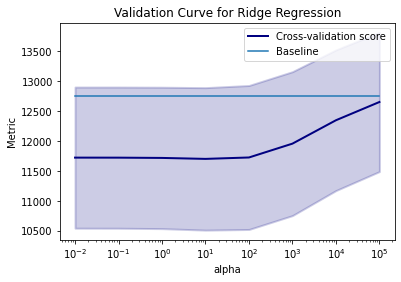

In [79]:
keys_dict = ["preprocessing__feature_selection_kendall_measure__treshold",\
            "preprocessing__generate_feature_hashtag__treshold", \
            "preprocessing__generate_feature_mentions__treshold", \
            "preprocessing__vectorize_stemming__min_df" \
            ]
best_param_values = [grid_ridge_regression.best_params_[key_name] for key_name in keys_dict]
index_validation = []

for index, cv_param in enumerate(grid_ridge_regression.cv_results_['params']):
    cv_param_values = [cv_param[key_name] for key_name in keys_dict]
    if cv_param_values == best_param_values:
        index_validation.append(index)
        
mean_test_score = - grid_ridge_regression.cv_results_["mean_test_RMSE"][index_validation]
std_test_score = grid_ridge_regression.cv_results_["std_test_RMSE"][index_validation]


title = "Validation Curve for Ridge Regression"
parameter = "alpha"
param_range = np.logspace(-2, 5, 8)
validation_curve_function(title, parameter, param_range, mean_test_score, std_test_score, baseline_scores_mse)

### Lasso Regression

In [80]:
from sklearn.linear_model import Lasso

pipeline_lasso_regression = Pipeline([
    ('preprocessing', pipeline_preprocessing),
    ('Lasso', Lasso())

])
lasso_alpha_param_range = np.logspace(-2, 5, 8)
param_grid_lasso_regression = {"preprocessing__generate_feature_hashtag__treshold": [10, 25],
              "preprocessing__generate_feature_mentions__treshold": [10, 25],
              "preprocessing__vectorize_stemming__min_df": [100, 200, 500],
              "preprocessing__feature_selection_kendall_measure__treshold": [0.01, 0.05],
              "Lasso__alpha": lasso_alpha_param_range
             }

grid_lasso_regression = GridSearchCV(pipeline_lasso_regression, param_grid_lasso_regression, cv=3, refit='RMSE', scoring = scoring)
grid_lasso_regression.fit(X_train, y_train)

print("Best Parameters: {}".format(grid_lasso_regression.best_params_))
print("\n Test Score (RMSE): {}".format(- grid_lasso_regression.best_score_))
print("Test Score (R2): {}".format(max(grid_lasso_regression.cv_results_['mean_test_R2'])))

best_test_scores.append(-grid_lasso_regression.best_score_ )
best_params_choice.append(grid_lasso_regression.best_params_)
best_algorithm_name.append("Lasso")


C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 768537590.083374, tolerance: 128775513.85453138
  positive)
C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12879286355.873657, tolerance: 132513333.51454769
  positive)
C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4909182875.667603, tolerance: 132513333.51454769
  positive)
C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

Best Parameters: {'Lasso__alpha': 10.0, 'preprocessing__feature_selection_kendall_measure__treshold': 0.01, 'preprocessing__generate_feature_hashtag__treshold': 10, 'preprocessing__generate_feature_mentions__treshold': 10, 'preprocessing__vectorize_stemming__min_df': 100}

 Test Score (RMSE): 11690.383120518154
Test Score (R2): 0.1795002786573705


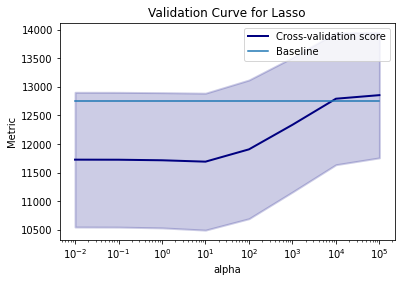

In [81]:
keys_dict = ["preprocessing__feature_selection_kendall_measure__treshold",\
            "preprocessing__generate_feature_hashtag__treshold", \
            "preprocessing__generate_feature_mentions__treshold", \
            "preprocessing__vectorize_stemming__min_df" \
            ]
best_param_values = [grid_lasso_regression.best_params_[key_name] for key_name in keys_dict]
index_validation = []
for index, cv_param in enumerate(grid_lasso_regression.cv_results_['params']):
    cv_param_values = [cv_param[key_name] for key_name in keys_dict]
    if cv_param_values == best_param_values:
        index_validation.append(index)
        
mean_test_score = - grid_lasso_regression.cv_results_["mean_test_RMSE"][index_validation]
std_test_score = grid_lasso_regression.cv_results_["std_test_RMSE"][index_validation]

title = "Validation Curve for Lasso"
parameter = "alpha"
validation_curve_function(title, parameter, lasso_alpha_param_range, mean_test_score, std_test_score, baseline_scores_mse)

#### K-Neighbor Regressor

In [82]:
pipeline_knn_regression = Pipeline([
    ('preprocessing', pipeline_preprocessing),
    ('KNN', KNeighborsRegressor())

])

n_neightbors_param_range = np.arange(5, 15)
param_grid_knn_regression = {"preprocessing__generate_feature_hashtag__treshold": [10, 25],
              "preprocessing__generate_feature_mentions__treshold": [10, 25],
              "preprocessing__vectorize_stemming__min_df": [100, 200, 500],
              "preprocessing__feature_selection_kendall_measure__treshold": [0.01, 0.05],
              "KNN__n_neighbors": n_neightbors_param_range
             }


grid_knn_regression = GridSearchCV(pipeline_knn_regression, param_grid_knn_regression, cv=3, refit='RMSE', scoring = scoring)
grid_knn_regression.fit(X_train, y_train)

print("Best Parameters: {}".format(grid_knn_regression.best_params_))
print("\n Test Score (RMSE): {}".format(- grid_knn_regression.best_score_))
print("Test Score (R2): {}".format(max(grid_knn_regression.cv_results_['mean_test_R2'])))


best_test_scores.append(-grid_knn_regression.best_score_)
best_params_choice.append(grid_knn_regression.best_params_)
best_algorithm_name.append("KNN")

Best Parameters: {'KNN__n_neighbors': 14, 'preprocessing__feature_selection_kendall_measure__treshold': 0.01, 'preprocessing__generate_feature_hashtag__treshold': 10, 'preprocessing__generate_feature_mentions__treshold': 10, 'preprocessing__vectorize_stemming__min_df': 500}

 Test Score (RMSE): 12319.7854482108
Test Score (R2): 0.0868231339650013


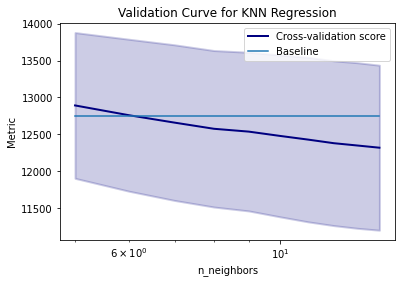

In [83]:
keys_dict = ["preprocessing__feature_selection_kendall_measure__treshold",\
            "preprocessing__generate_feature_hashtag__treshold", \
            "preprocessing__generate_feature_mentions__treshold", \
            "preprocessing__vectorize_stemming__min_df" \
            ]
best_param_values = [grid_knn_regression.best_params_[key_name] for key_name in keys_dict]
index_validation = []
for index, cv_param in enumerate(grid_knn_regression.cv_results_['params']):
    cv_param_values = [cv_param[key_name] for key_name in keys_dict]
    if cv_param_values == best_param_values:
        index_validation.append(index)
        
mean_test_score = - grid_knn_regression.cv_results_["mean_test_RMSE"][index_validation]
std_test_score = grid_knn_regression.cv_results_["std_test_RMSE"][index_validation]


title = "Validation Curve for KNN Regression"
parameter = "n_neighbors"
validation_curve_function(title, parameter, n_neightbors_param_range, mean_test_score, std_test_score, baseline_scores_mse)

#### Random forest tree

In [84]:
from sklearn.ensemble import RandomForestRegressor
pipeline_randomforest_regression = Pipeline([
    ('preprocessing', pipeline_preprocessing),
    ('RandomForestRegressor', RandomForestRegressor())

])

param_grid_randomforest_regression = {"preprocessing__generate_feature_hashtag__treshold": [10, 25],
              "preprocessing__generate_feature_mentions__treshold": [10, 25],
              "preprocessing__vectorize_stemming__min_df": [100, 200, 500],
              "preprocessing__feature_selection_kendall_measure__treshold": [0.01, 0.05],
              "RandomForestRegressor__max_depth": [10, 20],
              "RandomForestRegressor__n_estimators": [100, 200],
              "RandomForestRegressor__min_samples_split": [2, 5],
             }


grid_randomforest_regression = GridSearchCV(pipeline_randomforest_regression, param_grid_randomforest_regression, cv=3, refit='RMSE', scoring = scoring)
grid_randomforest_regression.fit(X_train, y_train)

print("Best Parameters: {}".format(grid_randomforest_regression.best_params_))
print("\n Test Score (RMSE): {}".format(-grid_randomforest_regression.best_score_))
print("Test Score (R2): {}".format(max(grid_randomforest_regression.cv_results_['mean_test_R2'])))


best_test_scores.append(-grid_randomforest_regression.best_score_)
best_params_choice.append(grid_randomforest_regression.best_params_)
best_algorithm_name.append("RandomForestRegressor")

Best Parameters: {'RandomForestRegressor__max_depth': 20, 'RandomForestRegressor__min_samples_split': 5, 'RandomForestRegressor__n_estimators': 200, 'preprocessing__feature_selection_kendall_measure__treshold': 0.01, 'preprocessing__generate_feature_hashtag__treshold': 10, 'preprocessing__generate_feature_mentions__treshold': 10, 'preprocessing__vectorize_stemming__min_df': 200}

 Test Score (RMSE): 11356.17119756322
Test Score (R2): 0.22609017261481423


#### Select best model

In [85]:
import math
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score

index_best = np.argmin(np.array(best_test_scores))


if best_algorithm_name[index_best] == 'KNN':
    estimator = KNeighborsRegressor()
elif best_algorithm_name[index_best] == 'LinearRegression':
    estimator = LinearRegression()
elif best_algorithm_name[index_best] == 'RidgeRegression':
    estimator = RidgeRegression()
elif best_algorithm_name[index_best] == 'Lasso':
    estimator = Lasso()
elif best_algorithm_name[index_best] == 'RandomForestRegressor':
    estimator = RandomForestRegressor()
else:
    print("No matching algorithm found.")

print(best_algorithm_name[index_best])
print("\n")
print(best_params_choice[index_best])
pipeline = Pipeline([
    ('preprocessing', pipeline_preprocessing),
    (best_algorithm_name[index_best], estimator)

])
print("\n")
estimator_baseline = LinearRegression()
time_diff_train = (X_train.values)[:, 7].reshape(-1, 1)
time_diff_test = (X_test.values)[:, 7].reshape(-1, 1)

estimator_baseline.fit(time_diff_train, y_train.values.reshape(-1, 1))
y_predict_baseline = estimator_baseline.predict(time_diff_test)
print("Baseline Generalization error (RMSE): {}".format(math.sqrt(mean_squared_error(y_test.values.reshape(-1, 1), y_predict_baseline))))
print("Baseline R2: {}".format(r2_score(y_test.values.reshape(-1, 1), y_predict_baseline)))

model = pipeline.set_params(**best_params_choice[index_best])
model.fit(X_train, y_train)
y_predict = pipeline.predict(X_test)
print("\nGeneralization error (RMSE): {}".format(math.sqrt(mean_squared_error(y_test, y_predict))))
print("R2: {}".format(r2_score(y_test, y_predict)))

RandomForestRegressor


{'RandomForestRegressor__max_depth': 20, 'RandomForestRegressor__min_samples_split': 5, 'RandomForestRegressor__n_estimators': 200, 'preprocessing__feature_selection_kendall_measure__treshold': 0.01, 'preprocessing__generate_feature_hashtag__treshold': 10, 'preprocessing__generate_feature_mentions__treshold': 10, 'preprocessing__vectorize_stemming__min_df': 200}


Baseline Generalization error (RMSE): 12649.430594588302
Baseline R2: 0.0032336514145449025

Generalization error (RMSE): 11434.579578466642
R2: 0.1854986337419512


In [86]:
# save model
from sklearn.externals import joblib 
joblib.dump(model, 'model.pkl')
# save lists with best scores, parameters and algorithms
joblib.dump(best_test_scores, 'best_test_scores.pkl') 
joblib.dump(best_params_choice, 'best_params_choice.pkl') 
joblib.dump(best_algorithm_name, 'best_algorithm_name.pkl') 

C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['best_algorithm_name.pkl']

## Feature importance
Check the feature importance of the best model

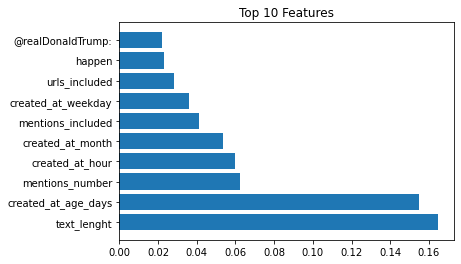

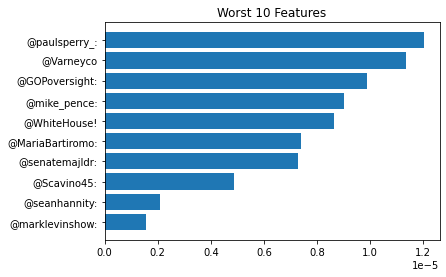

In [97]:
# Visualize best features
features = pipeline["preprocessing"].transform(X_train).keys()
coefficients = pipeline[best_algorithm_name[index_best]].feature_importances_
dictionary = dict(zip(features, coefficients))
sorted_dictionary = {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1], reverse=True)}

top_features = dict(list(sorted_dictionary.items())[:10])

fig = plt.figure()
ax = fig.add_subplot(111)

colours = {'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'b', 'g'}
   
y_pos = np.arange(len(top_features.keys()))

# Create horizontal bars
plt.barh(y_pos, top_features.values())

# Create names on the y-axis
plt.yticks(y_pos, top_features.keys())
plt.title("Top 10 Features")

# Show graphic
plt.show()



# Visualize worst features
features = pipeline["preprocessing"].transform(X_train).keys()
coefficients = pipeline[best_algorithm_name[index_best]].feature_importances_
dictionary = dict(zip(features, coefficients))
sorted_dictionary = {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1], reverse=False)}

worst_features = dict(list(sorted_dictionary.items())[:10])
    
y_pos = np.arange(len(top_features.keys()))

# Create horizontal bars
plt.barh(y_pos, worst_features.values())
 
# Create names on the y-axis
plt.yticks(y_pos, worst_features.keys())
plt.title("Worst 10 Features")

 
# Show graphic
plt.show()

In [87]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [88]:
explainer = shap.TreeExplainer(model)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


SHAPError: Model type not yet supported by TreeExplainer: <class 'sklearn.pipeline.Pipeline'>

In [ ]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")


explainer = shap.TreeExplainer(pipeline)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

shap.force_plot(explainer.expected_value, shap_values, X)

SHAP

In [ ]:

# shap comes with pre-built explainers for pretty much any model
# important: ONLY pass training data to explainer!
exp = shap.TreeExplainer(l, x_train)

In [ ]:
# load JS visualization code to notebook and showcase what changed a single prediction
shap.initjs()
shap.force_plot(exp.expected_value, shap_vals[0,:], x_test.iloc[0,:])

## Results

How good is the result? Which variables are important?

In [ ]:
from IPython.display import Javascript
display(Javascript('IPython.notebook.execute_cells_above()'))

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(twitterdata_train, explorative=True, minimal=True, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_notebook_iframe()

In [143]:
data = preprocess_text(twitterdata)

def tokenize(text):
    return text.split()

list_of_list_of_tokens = []

for index, row in data.iterrows():
    list_of_list_of_tokens.append(tokenize(row["text"]))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

